In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
sys.path.append('../src')

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import pyro
import spaceoracle
from spaceoracle import SpaceOracle
from spaceoracle.tools.utils import clean_up_adata

2024-10-25 13:48:40.555467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from spaceoracle.tools.data import LigRecDataset

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

import scanpy as sc

In [6]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator
from spaceoracle.models.pixel_attention import CellularNicheNetwork

In [7]:
adata_train = sc.read_h5ad('.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [25]:
data_path = '/ix/djishnu/alw399/SpaceOracle/data/ligand_target_mouse.parquet'
nichenet_ligand_target = pd.read_parquet(data_path)

set(nichenet_ligand_target.columns) & set(adata_train.var_names)


{'Abca1',
 'Adam10',
 'Adam17',
 'Adam23',
 'Adgre5',
 'Adgrf5',
 'Adipoq',
 'Adm',
 'Alcam',
 'Alox5ap',
 'Angpt2',
 'Angptl2',
 'Angptl4',
 'Antxr1',
 'Anxa1',
 'Anxa2',
 'Apoc1',
 'Apoe',
 'App',
 'Atp1b1',
 'B2m',
 'Bace2',
 'Bmp1',
 'Bmp2',
 'Bst2',
 'Btla',
 'C1qa',
 'C1qb',
 'C3',
 'C4b',
 'Calm1',
 'Car12',
 'Ccl11',
 'Ccl12',
 'Ccl17',
 'Ccl2',
 'Ccl20',
 'Ccl22',
 'Ccl25',
 'Ccl4',
 'Ccl5',
 'Ccl6',
 'Ccl7',
 'Ccl8',
 'Ccl9',
 'Ccn1',
 'Ccn2',
 'Ccn4',
 'Cd14',
 'Cd160',
 'Cd209b',
 'Cd209d',
 'Cd209e',
 'Cd22',
 'Cd226',
 'Cd24a',
 'Cd300a',
 'Cd300c',
 'Cd300lf',
 'Cd34',
 'Cd40',
 'Cd44',
 'Cd55',
 'Cd59a',
 'Cd5l',
 'Cd79b',
 'Cd80',
 'Cd86',
 'Cd9',
 'Cd96',
 'Cdh13',
 'Cdh5',
 'Cfd',
 'Cfp',
 'Cklf',
 'Clcf1',
 'Clec4g',
 'Clu',
 'Col1a2',
 'Col3a1',
 'Col4a1',
 'Col4a2',
 'Col6a3',
 'Cp',
 'Csf1',
 'Ctsd',
 'Cxcl1',
 'Cxcl10',
 'Cxcl12',
 'Cxcl13',
 'Cxcl16',
 'Cxcl9',
 'Dchs1',
 'Dcn',
 'Dll4',
 'Dsc2',
 'Dsg2',
 'Ebi3',
 'Ecm1',
 'Efemp2',
 'Efna1',
 'Efna4',
 'Efnb2

In [166]:
estimator = SpatialCellularProgramsEstimator(
    adata=adata_train,
    target_gene='Vcam1',
)

In [168]:
estimator.lr.shape

(27, 5)

In [171]:
len(estimator.tfl_pairs)

103

In [172]:
%%time

glasso_results = estimator.fit(
    num_epochs=1, 
    threshold_lambda=1e-5, 
    discard=50,
    learning_rate=1e-3,
    use_ARD=False,
    testing=2,
    clip_betas=10
    )


CPU times: user 23.3 s, sys: 2.3 s, total: 25.6 s
Wall time: 28 s


In [173]:
%%time

ard_results = estimator.fit(
    num_epochs=1, 
    threshold_lambda=3e3, 
    # discard=50,
    learning_rate=1e-3,
    use_ARD=True,
    testing=2,
    clip_betas=10
    )

CPU times: user 21.6 s, sys: 2.32 s, total: 24 s
Wall time: 28.4 s


In [174]:
chosen = ard_results['cluster']

print(f'Comparing initial beta guesses for cluster {chosen}')
print(ard_results['r2_ard'], glasso_results['r2_ard'])

ard_results.keys()

Comparing initial beta guesses for cluster 2
0.38703264008785343 0.47801968115536875


dict_keys(['y_pred', 'r2_ard', 'betas', 'coefs', 'cluster', 'X_cell'])

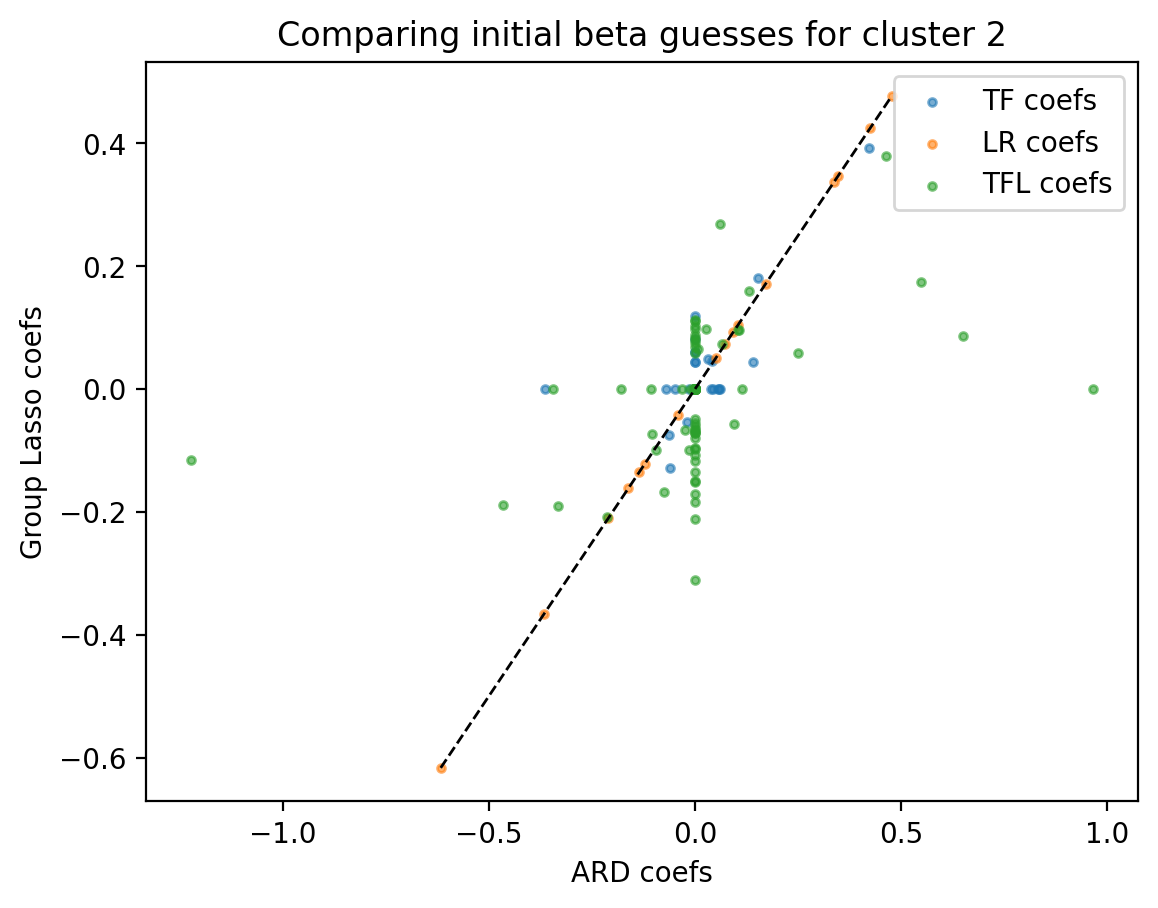

In [179]:
x_tf = ard_results['betas'][1:1+len(estimator.regulators)]
y_tf = glasso_results['betas'][1:1+len(estimator.regulators)]

x_lr = ard_results['betas'][1+len(estimator.regulators):-len(estimator.tfl_pairs):]
y_lr = ard_results['betas'][1+len(estimator.regulators):-len(estimator.tfl_pairs):]

x_tfl = ard_results['betas'][-len(estimator.tfl_pairs):]
y_tfl = glasso_results['betas'][-len(estimator.tfl_pairs):]

plt.scatter(x_tf, y_tf, s=8, alpha=0.6, label='TF coefs')
plt.scatter(x_lr, y_lr, s=8, alpha=0.6, label='LR coefs')
plt.scatter(x_tfl, y_tfl, s=8, alpha=0.6, label='TFL coefs')

min_val = np.min(np.concatenate([x_tf, y_tf, x_lr, y_lr]))  
max_val = np.max(np.concatenate([x_tf, y_tf, x_lr, y_lr]))  
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel('ARD coefs')
plt.ylabel('Group Lasso coefs')
plt.title(f'Comparing initial beta guesses for cluster {chosen}')
plt.legend()

IndexError: index 2 is out of bounds for axis 0 with size 2

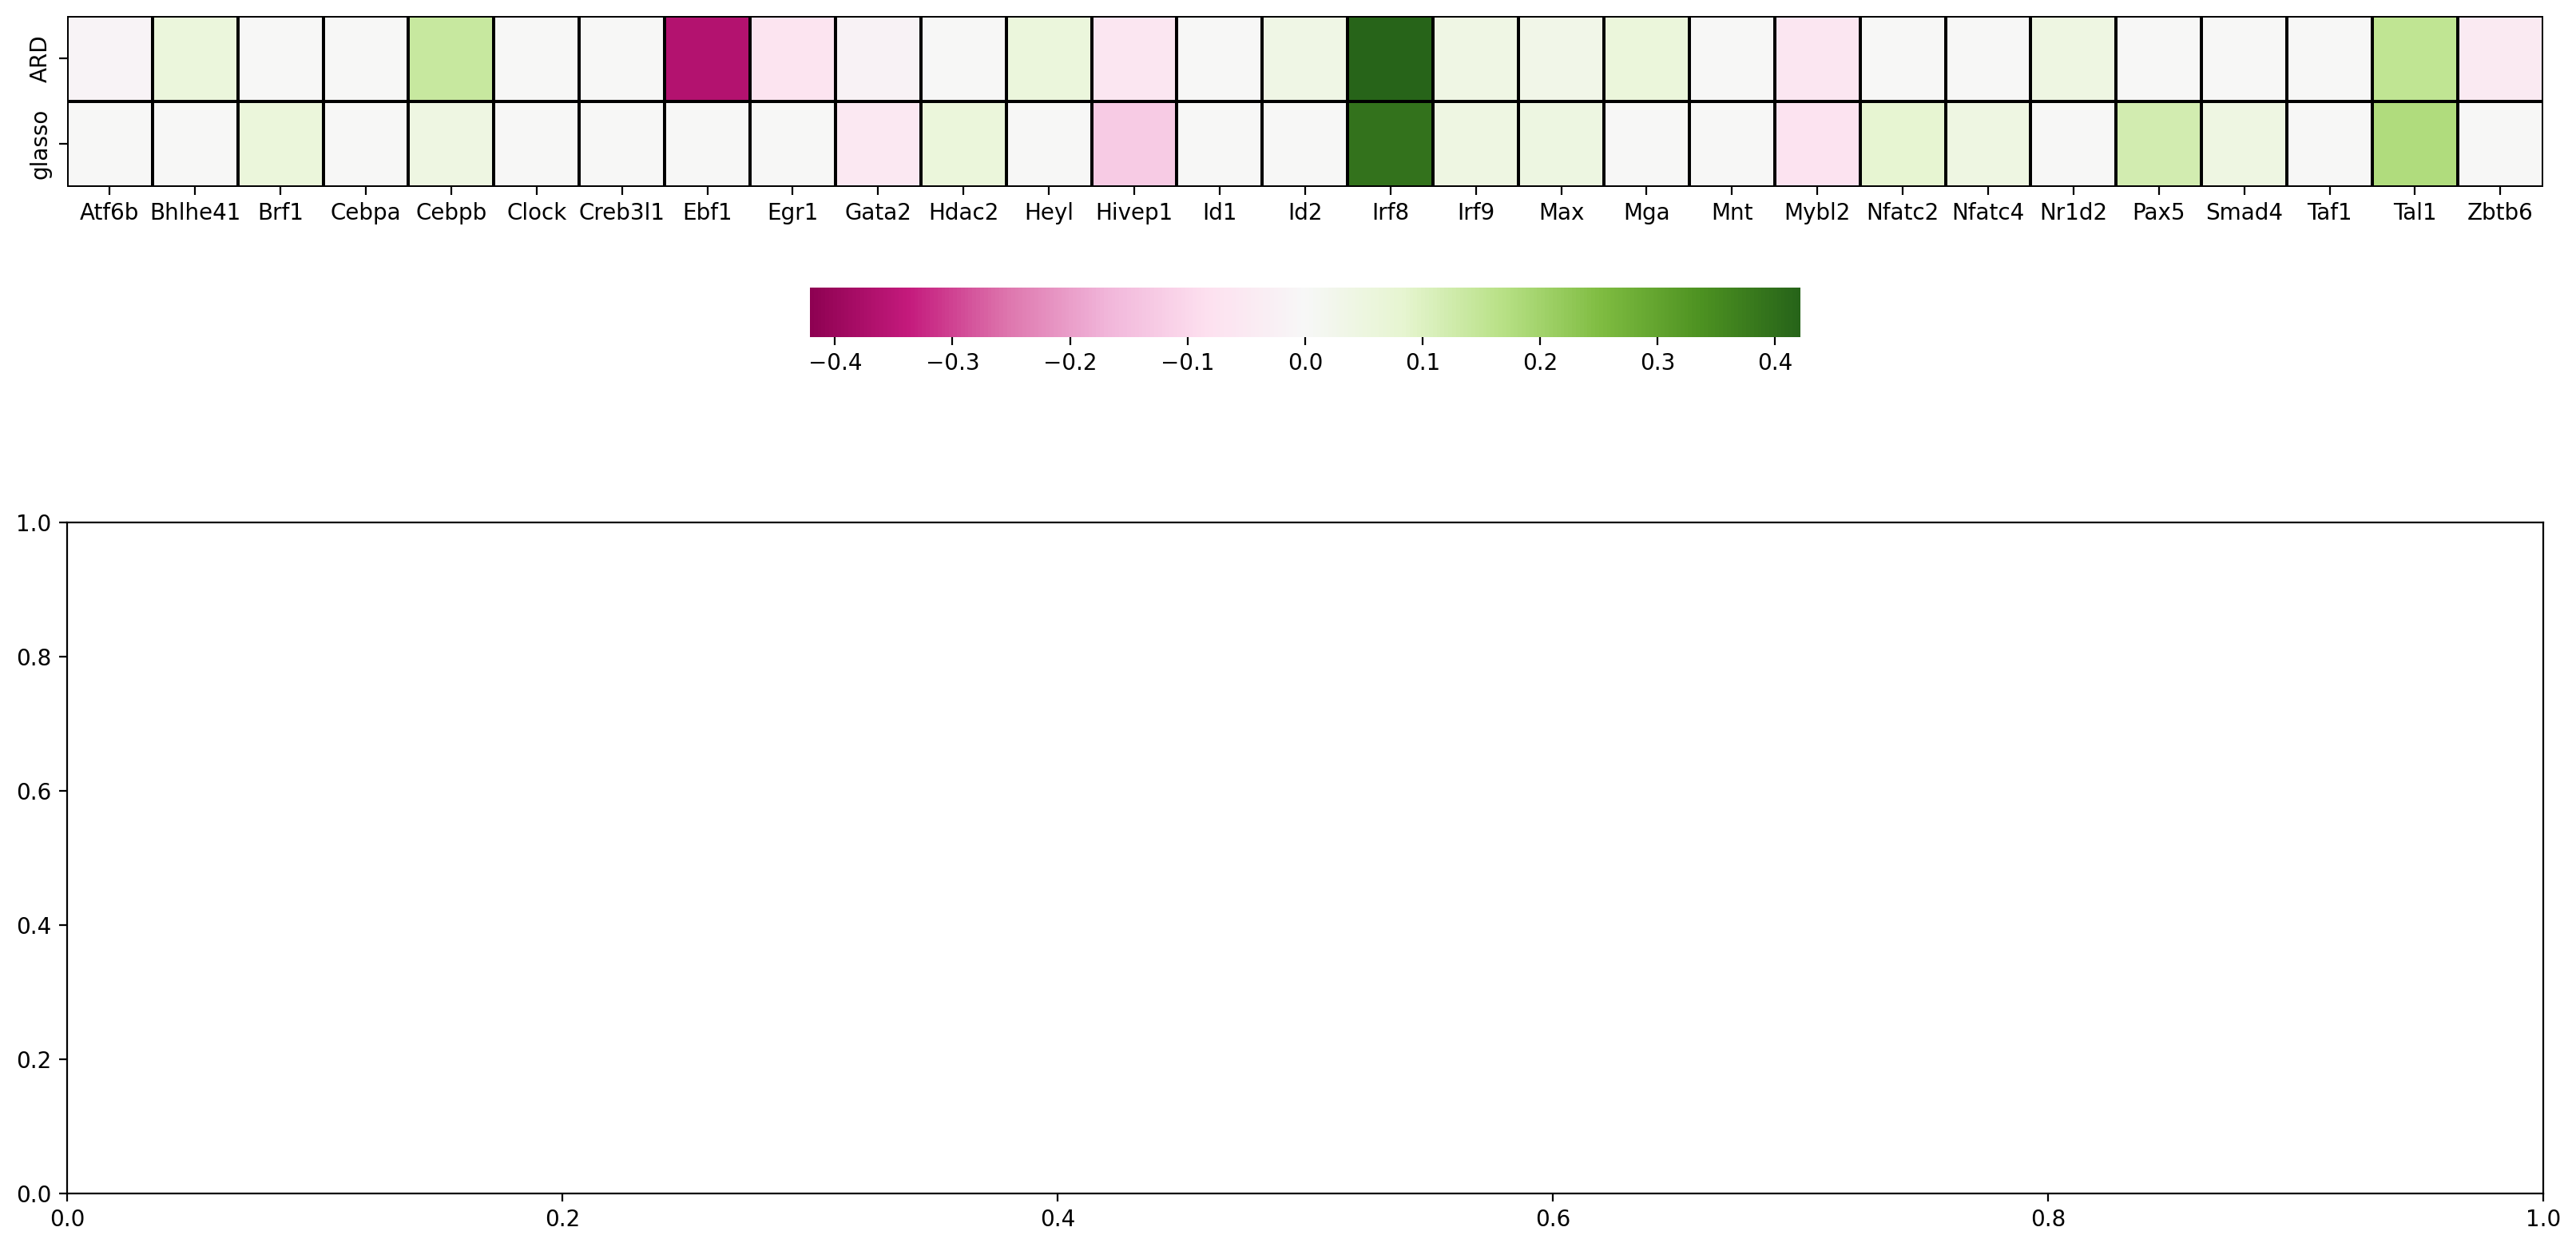

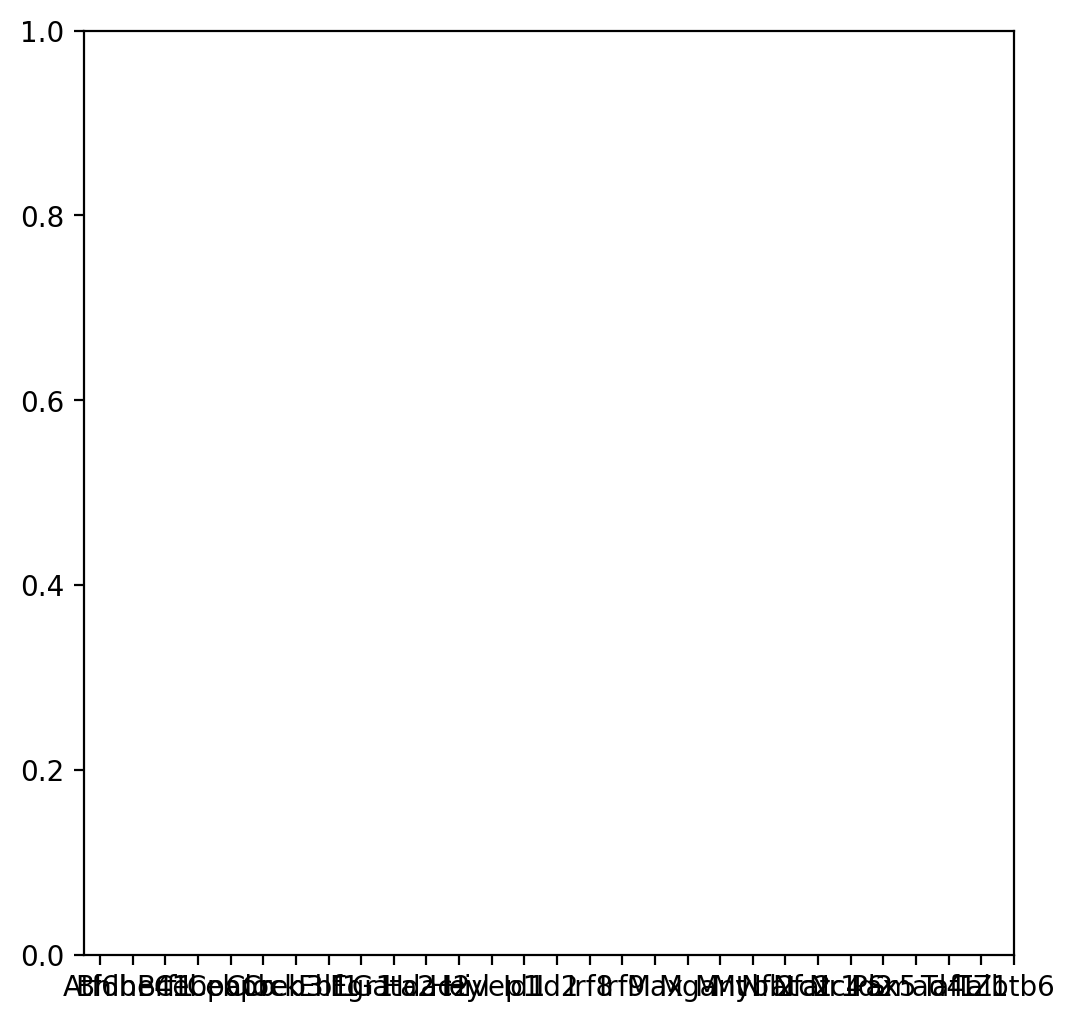

In [221]:
import seaborn as sns

fig, axes = plt.subplots(2, figsize=(20, 12))

df_tf = pd.DataFrame({
    'ARD': x_tf,
    'glasso': y_tf
    }, index = estimator.regulators).T

minmax = max(abs(np.min(df_tf.values)), np.max(df_tf.values))
plt.figure(figsize=(6, 6))
sns.heatmap(df_tf, linecolor='black', linewidths=0.8, cmap='PiYG', square=True, 
            vmin=-minmax, vmax=minmax, ax=axes[0], 
            cbar_kws={"shrink": 0.4, "orientation": "horizontal"})
plt.xticks(ticks=np.arange(len(df_tf.columns)) + 0.5, labels=df_tf.columns)

sns.heatmap(np.where(df_tf > 0, 1, 0), linecolor='black', linewidths=0.8, cmap='Blues', square=True, 
            ax=axes[1], cbar_kws={"shrink": 0.4, "orientation": "horizontal"})
plt.xticks(ticks=np.arange(len(df_tf.columns)) + 0.5, labels=df_tf.columns)

plt.title(f'Comparing initial TF beta guesses for cluster {chosen}')
plt.tight_layout()

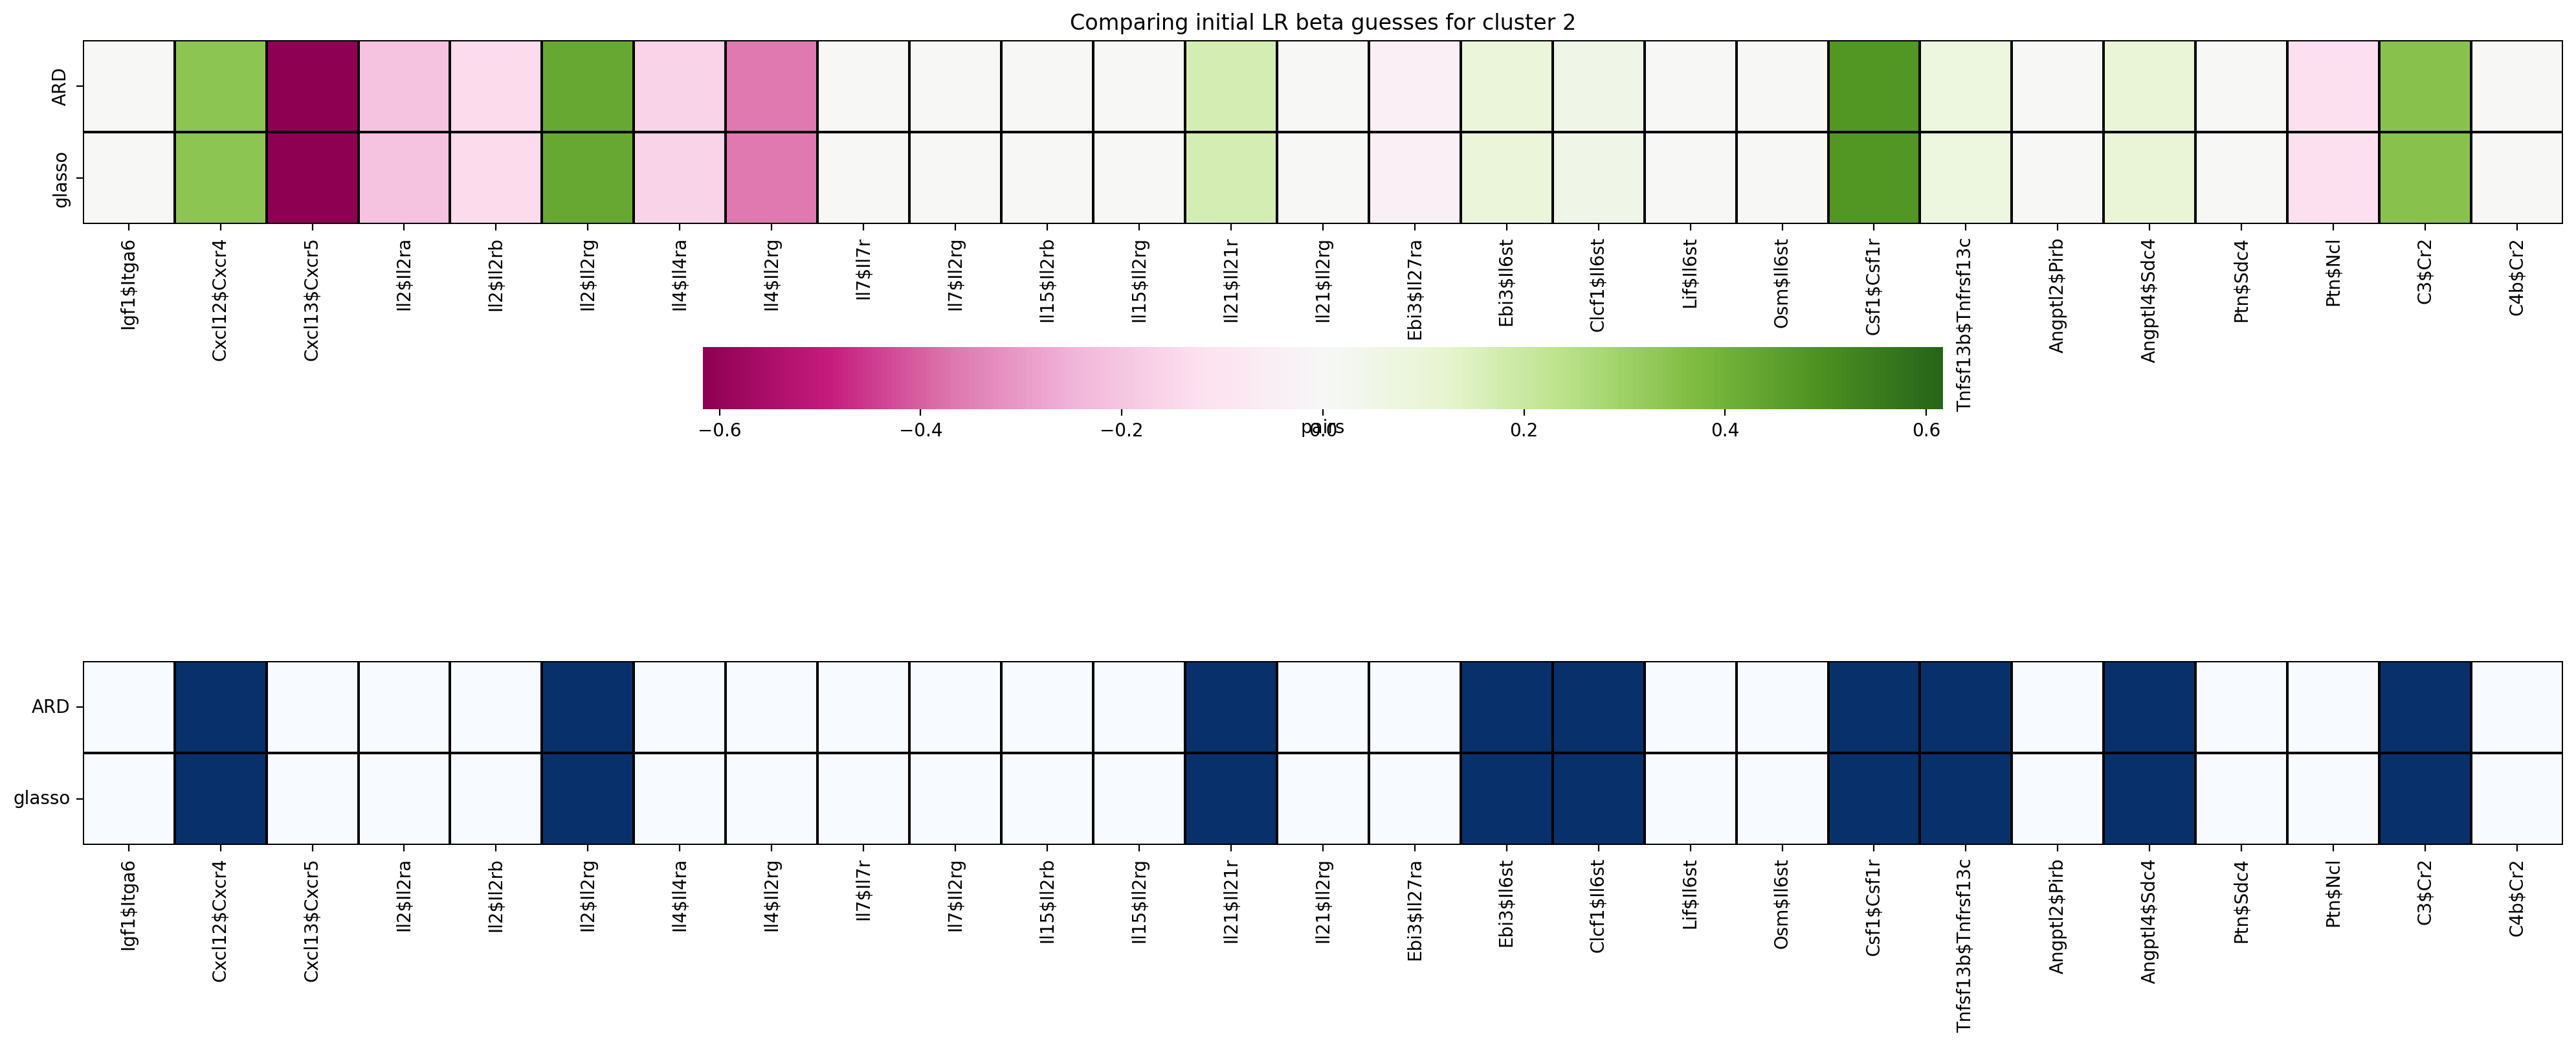

In [208]:
fig, axes = plt.subplots(2, figsize=(20, 12))

df_coef = pd.DataFrame({
    'ARD': x_lr,
    'glasso': y_lr
    },index = estimator.lr['pairs']).T

minmax = max(abs(np.min(df_coef.values)), np.max(df_coef.values))

# Continuous betas 
sns.heatmap(
    df_coef, 
    ax=axes[0], 
    linecolor='black', 
    linewidths=0.8, 
    cmap='PiYG', 
    square=True, 
    vmin=-minmax, 
    vmax=minmax,
    cbar_kws={"shrink": 0.5, "orientation": "horizontal"}
)
axes[0].set_title(f'Comparing initial LR beta guesses for cluster {chosen}')
axes[0].set_xticks(np.arange(len(df_coef.columns)) + 0.5)
axes[0].set_xticklabels(df_coef.columns, rotation=90)


# Binary visualization
sns.heatmap(
    np.where(df_coef > 0, 1, 0), 
    ax=axes[1], 
    linecolor='black', 
    linewidths=0.8, 
    cmap='Blues', 
    square=True, 
    cbar=False  # No color bar
)
axes[1].set_yticks([0.5, 1.5])
axes[1].set_yticklabels(['ARD', 'glasso'], rotation=0)
axes[1].set_xticks(np.arange(len(df_coef.columns)) + 0.5)
axes[1].set_xticklabels(df_coef.columns, rotation=90)

plt.tight_layout()
plt.show()

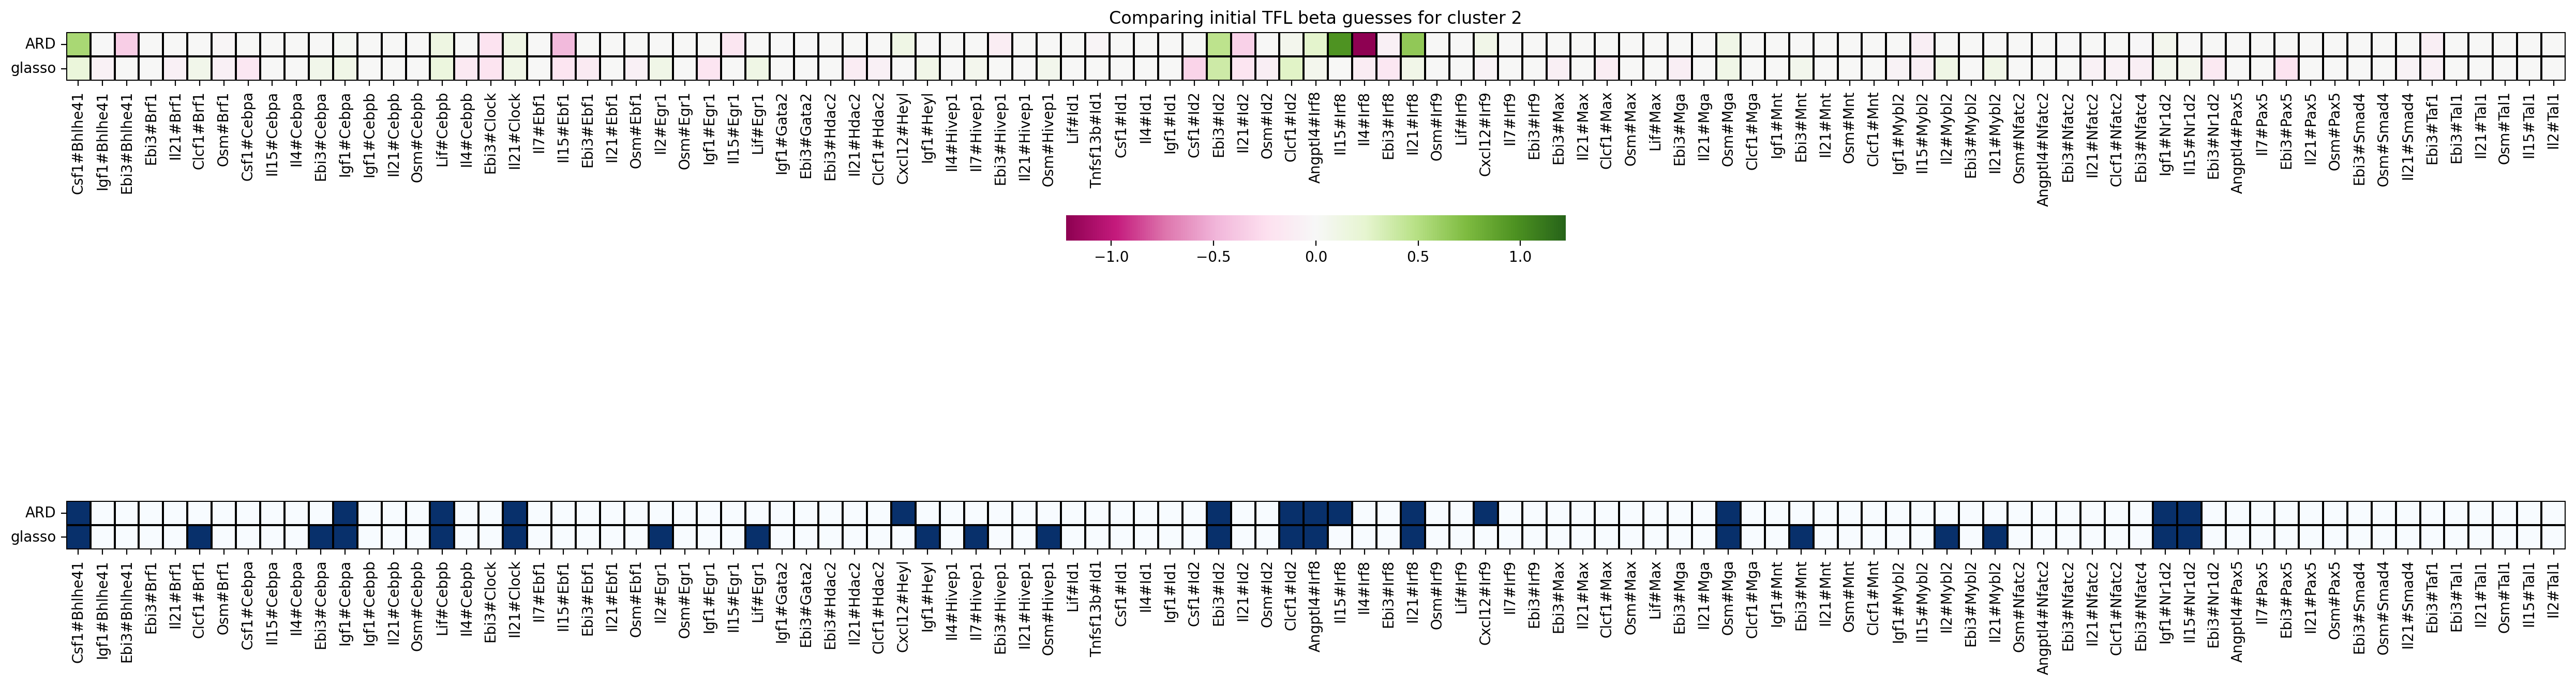

In [219]:
fig, axes = plt.subplots(2, figsize=(25, 15))

df_tfl = pd.DataFrame({
    'ARD': x_tfl,
    'glasso': y_tfl
    },index = estimator.tfl_pairs).T

minmax = max(abs(np.min(df_tfl.values)), np.max(df_tfl.values))

# First heatmap for continuous values 
sns.heatmap(
    df_tfl, 
    ax=axes[0], 
    linecolor='black', 
    linewidths=0.8, 
    cmap='PiYG', 
    square=True, 
    vmin=-minmax, 
    vmax=minmax,
    cbar_kws={"shrink": 0.2, "orientation": "horizontal"}
)
axes[0].set_xticks(np.arange(len(df_tfl.columns)) + 0.5)
axes[0].set_xticklabels(df_tfl.columns, rotation=90)
axes[0].set_title(f'Comparing initial TFL beta guesses for cluster {chosen}')


# Second heatmap for binary values 
sns.heatmap(
    np.where(df_tfl > 0, 1, 0), 
    ax=axes[1], 
    linecolor='black', 
    linewidths=0.8, 
    cmap='Blues', 
    square=True, 
    cbar=False  # No color bar
)
axes[1].set_yticks([0.5, 1.5])
axes[1].set_yticklabels(['ARD', 'glasso'], rotation=0)
axes[1].set_xticks(np.arange(len(df_tfl.columns)) + 0.5)
axes[1].set_xticklabels(df_tfl.columns, rotation=90)

plt.tight_layout()
plt.show()